# 1) Modules Importing

In [1]:
import pandas as pd
import numpy as np 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

## 1.1) Loading the Dataset

In [5]:
Df = '../input/utkface-new/UTKFace/'

## 1.2) Labels, Age, Gender, Ethnicity

In [6]:
## Defining an Empty Lists for Each

image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(Df)):
    image_path = os.path.join(Df, filename)
    ## Splitting the Filename into Age, Gender, Ethnicity As --> 100_0_0_20170112213500903
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)


  0%|          | 0/23708 [00:00<?, ?it/s]

## After Storing about 23708 Images 
## 1.3) We will convert them into a DataFrame

In [9]:
df = pd.DataFrame()
df['image'],df['age'],df['gender'] = image_paths, age_labels, gender_labels

df.head()

,image,age,gender
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26,0
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22,1
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,21,1
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,28,0
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17,1


## 1.4) Creating A Gender Dictionary (Male & Female)

In [10]:
gender_dict = {0:'Male', 1:'Female'}

***
# 2) Data Analysis

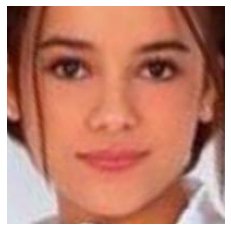

In [17]:
from PIL import Image
img = Image.open(df['image'][10])
plt.axis('off')
plt.imshow(img);


## 2.1) Seaborn Plotting for showing the Average AGE and Genders Among the Dataset

<AxesSubplot:xlabel='age', ylabel='Density'>

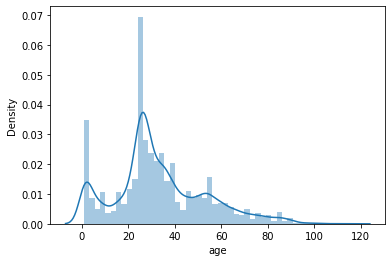

In [18]:
sns.distplot(df['age'])

<AxesSubplot:xlabel='gender', ylabel='count'>

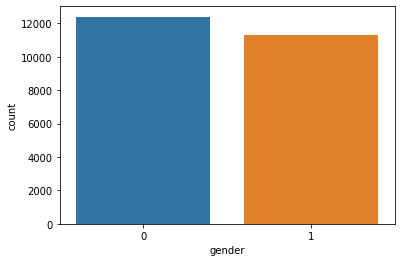

In [19]:
sns.countplot(df['gender'])

## 2.2) Adjusting the Size and grid of the Images

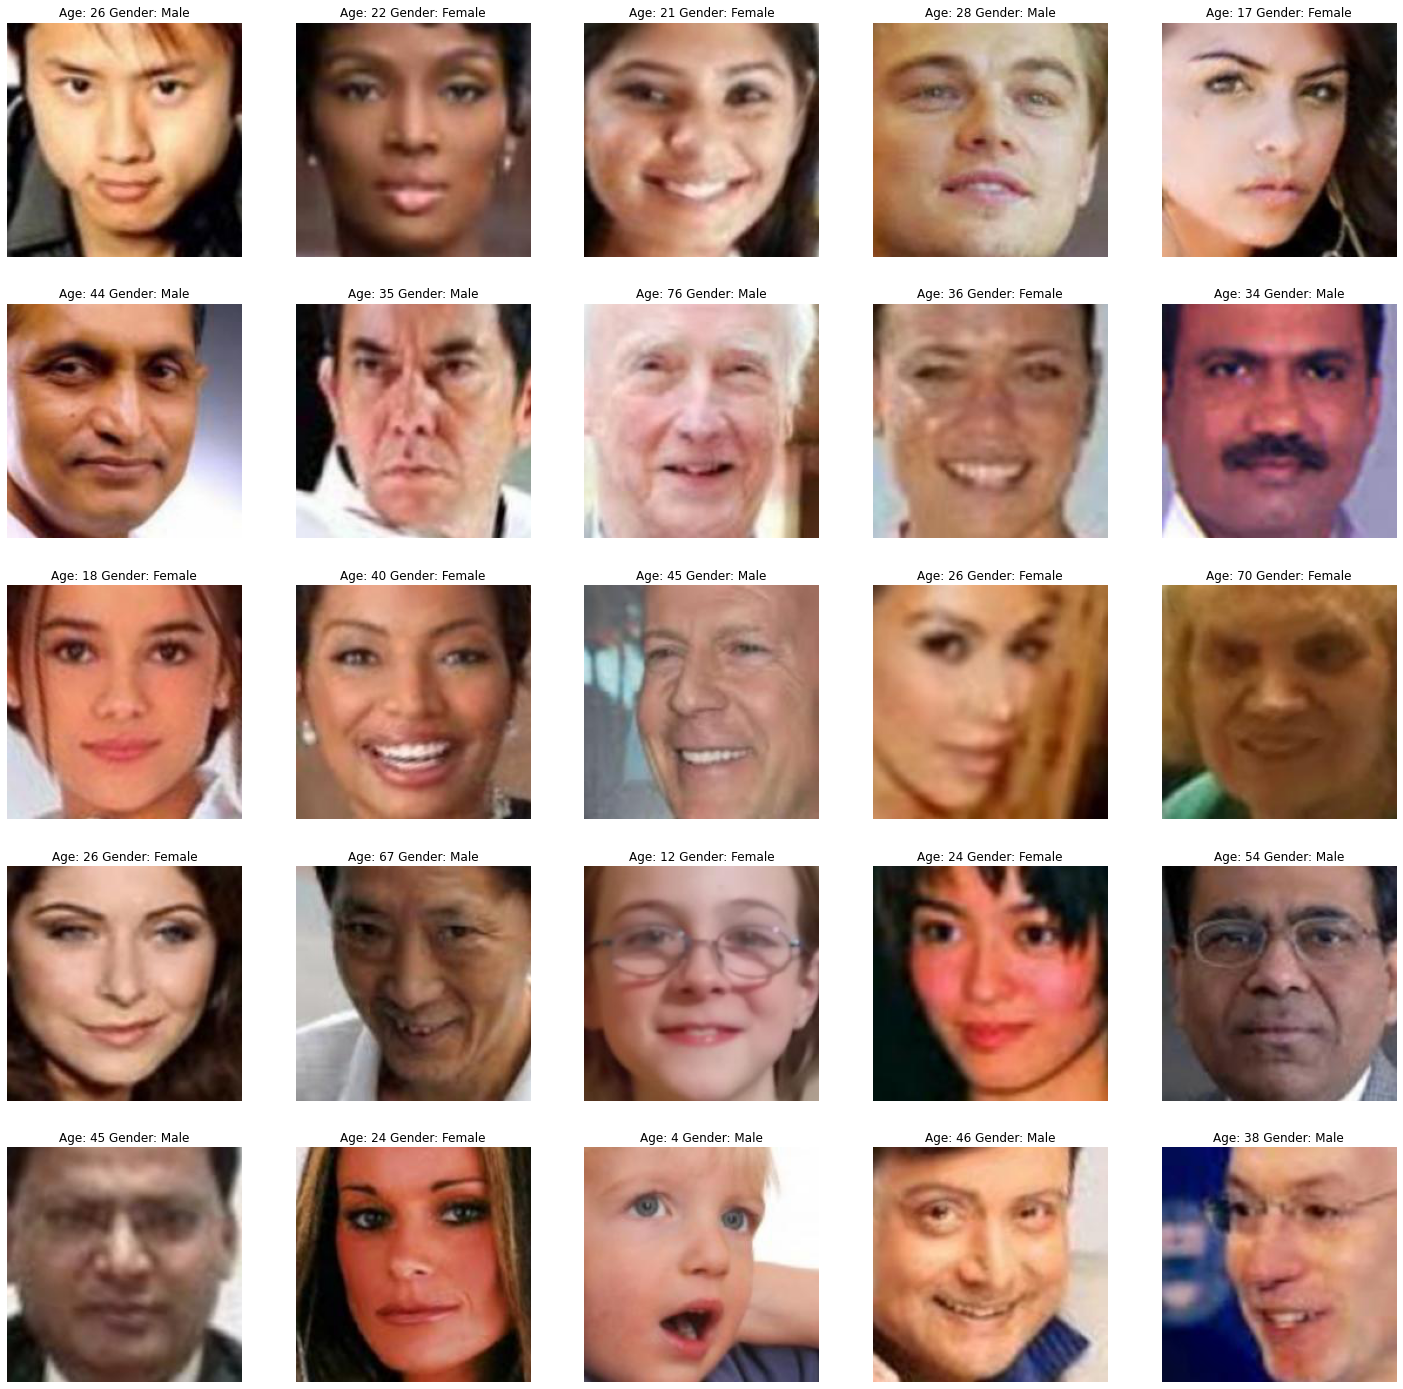

In [23]:
plt.figure(figsize=(25, 25))
files = df.iloc[0:25]   ##Iloc --> Search by Index

for index, file, age, gender in files.itertuples():  ##Iterating the DataFrame
    plt.subplot(5, 5, index+1)    ## 5*5 --> 25
    
    img = load_img(file)
    img = np.array(img)    ##Load As an Array
    
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off') ## Ignoring the Axis Numbers

***
# 3) Feature Extraction

In [29]:
def extract_features(images):
    
    features = [] 
    for image in tqdm(images):
        
        img = load_img(image, grayscale = True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    ## Constant Reshaping Scale for grayscaling Only
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [30]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [31]:
X.shape

(23708, 128, 128, 1)

## 3.1) Normalizing the Images

In [32]:
X = X/255.0 
## As Pixeling is from 0 --> 255

In [34]:
Y_gender = np.array(df['gender'])
Y_age = np.array(df['age'])

In [36]:
input_shape = (128, 128, 1)


# Model Creation

In [39]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation = 'relu') (inputs)
maxpool_1 = MaxPooling2D(pool_size = (2, 2)) (conv_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation = 'relu') (maxpool_1)
maxpool_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation = 'relu') (maxpool_2)
maxpool_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation = 'relu') (maxpool_3)
maxpool_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)

flatten = Flatten() (maxpool_4)

# Fully Connected Layers

# Dense Layers
dense_1 = Dense(256,activation = 'relu') (flatten)
dense_2 = Dense(256,activation = 'relu') (flatten)
# Dropout Layers
dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)
# Output Layers
output_1 = Dense(1, activation='sigmoid', name ='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name ='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer = 'adam', metrics = ['accuracy'])

***

In [40]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 126, 126, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 63, 63, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 61, 61, 64)   18496       max_pooling2d_4[0][0]            
______________________________________________________________________________________________

***
## Model plotting

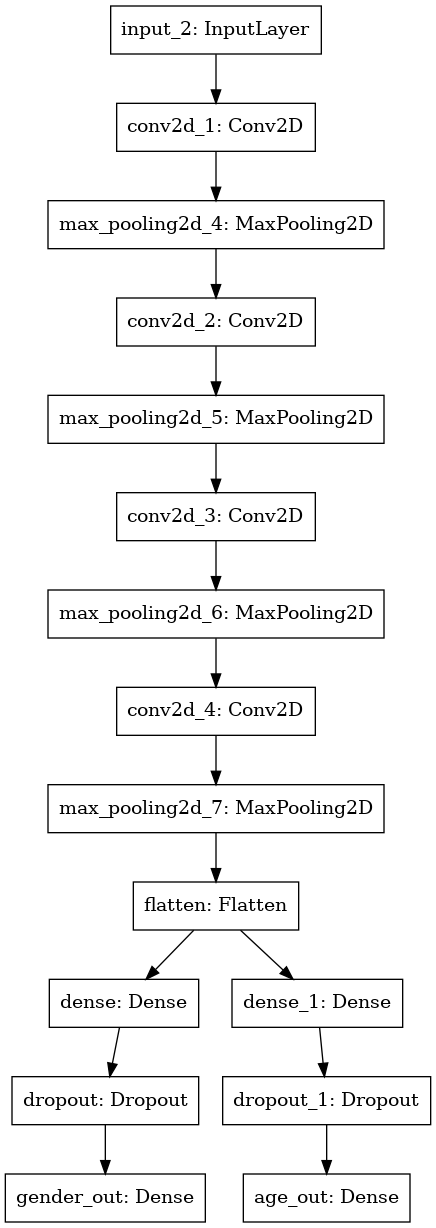

In [41]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [46]:
history = model.fit(x=X, y=[Y_gender, Y_age], batch_size = 32, epochs = 20, validation_split = 0.2)

Epoch 1/20
593/593 [==============================] - 223s 375ms/step - loss: 14.3321 - gender_out_loss: 0.6240 - age_out_loss: 13.7082 - gender_out_accuracy: 0.6240 - age_out_accuracy: 0.0459 - val_loss: 11.5665 - val_gender_out_loss: 0.4852 - val_age_out_loss: 11.0813 - val_gender_out_accuracy: 0.7674 - val_age_out_accuracy: 0.0380
Epoch 2/20
593/593 [==============================] - 223s 377ms/step - loss: 10.9866 - gender_out_loss: 0.4534 - age_out_loss: 10.5332 - gender_out_accuracy: 0.7853 - age_out_accuracy: 0.0279 - val_loss: 10.0773 - val_gender_out_loss: 0.4291 - val_age_out_loss: 9.6482 - val_gender_out_accuracy: 0.7992 - val_age_out_accuracy: 0.0162
Epoch 3/20
593/593 [==============================] - 224s 379ms/step - loss: 9.4976 - gender_out_loss: 0.3975 - age_out_loss: 9.1001 - gender_out_accuracy: 0.8172 - age_out_accuracy: 0.0166 - val_loss: 8.9728 - val_gender_out_loss: 0.3738 - val_age_out_loss: 8.5990 - val_gender_out_accuracy: 0.8279 - val_age_out_accuracy: 0.01

***
# Plotting Out the Results of the 20 Epoches

## Accuracy Plot Graph (Gender)

<Figure size 432x288 with 0 Axes>

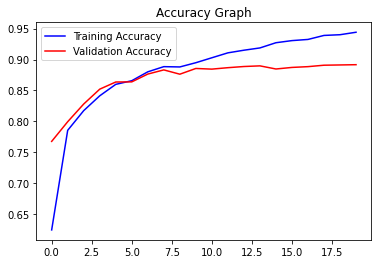

<Figure size 432x288 with 0 Axes>

In [48]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

***
## Loss Plot Graph (Gender)

<Figure size 432x288 with 0 Axes>

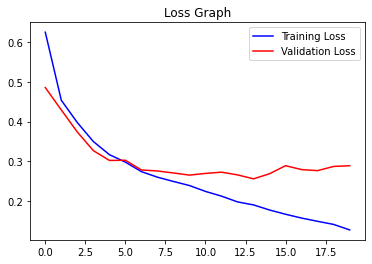

<Figure size 432x288 with 0 Axes>

In [50]:
loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.figure()

***
## Accuracy Plot Graph (Age)

<Figure size 432x288 with 0 Axes>

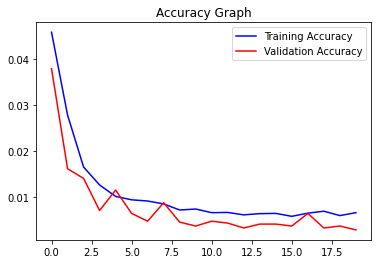

<Figure size 432x288 with 0 Axes>

In [51]:
acc = history.history['age_out_accuracy']
val_acc = history.history['val_age_out_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

***
## Loss Plot Graph (Age)

<Figure size 432x288 with 0 Axes>

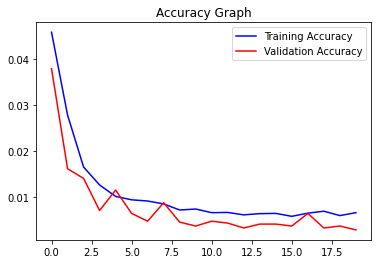

<Figure size 432x288 with 0 Axes>

In [52]:
loss = history.history['age_out_accuracy']
val_loss = history.history['val_age_out_accuracy']

epochs = range(len(loss))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

***
# Model Prediction

Original gender: Female Original Age 85
Predicted gender: Female Predicted Age 84


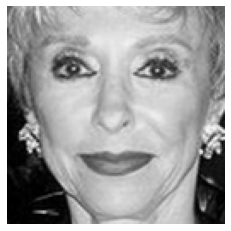

In [68]:
image_index = 105
print("Original gender:", gender_dict[Y_gender[image_index]], "Original Age", Y_age[image_index])

Pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
Pred_gender = gender_dict[round(Pred[0][0][0])]
Pred_age = round(Pred[1][0][0])

print("Predicted gender:", Pred_gender, "Predicted Age", Pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original gender: Female Original Age 26
Predicted gender: Female Predicted Age 23


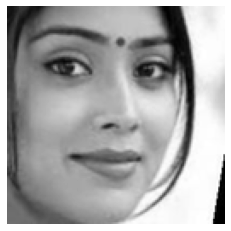

In [73]:
image_index = 5000
print("Original gender:", gender_dict[Y_gender[image_index]], "Original Age", Y_age[image_index])

Pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
Pred_gender = gender_dict[round(Pred[0][0][0])]
Pred_age = round(Pred[1][0][0])

print("Predicted gender:", Pred_gender, "Predicted Age", Pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original gender: Male Original Age 28
Predicted gender: Male Predicted Age 28


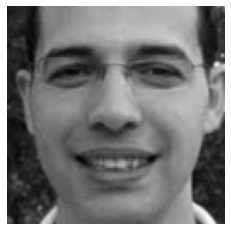

In [74]:
image_index = 3000
print("Original gender:", gender_dict[Y_gender[image_index]], "Original Age", Y_age[image_index])

Pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
Pred_gender = gender_dict[round(Pred[0][0][0])]
Pred_age = round(Pred[1][0][0])

print("Predicted gender:", Pred_gender, "Predicted Age", Pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

***